# Exploring the Very Basics of OLS Regression

Notes:
BLUE
multiple linear/multicollinear
test & compare

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Load in data

In [66]:
prostate_df = pd.read_pickle('Data/prostate.pkl')

In [67]:
prostate_df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,train,lpsa
0,-1.523680,-1.797414,-1.965590,-0.995955,-0.533063,-0.836769,-1.031712,-0.896487,T,-0.430783
1,-1.857204,-0.643057,-0.899238,-0.995955,-0.533063,-0.836769,-1.031712,-0.896487,T,-0.162519
2,-1.468157,-1.961526,1.233468,-0.995955,-0.533063,-0.836769,0.378996,-0.213934,T,-0.162519
3,-2.025981,-0.720349,-0.899238,-0.995955,-0.533063,-0.836769,-1.031712,-0.896487,T,-0.162519
4,-0.452342,-0.406493,-0.366061,-0.995955,-0.533063,-0.836769,-1.031712,-0.896487,T,0.371564


For this data we are trying to predict/explain lpsa with the other columns

This data comes from Elements of Statistical Learning and has a train column that splits the data into a training and testing set

The data has been prepared the same way as the book with the features standardized for test and training sets

## Assumptions
This notebook won't get into these much, but here are the basics:
1. Linearity - the independent and dependent variables have a linear relationship
2. Independence - the errors are independent
3. Homoscedascity - the errors have the same finite variance
4. Normality - errors are normally distributed with a mean of 0
5. No multicollinearity - features are not linearly dependent (automatically true for simple linear regression) 

## Simple linear regression
Seeing how one feature, x, explains y

For now, I will focus on just using lcavol and lpsa 

In [68]:
X_train = np.array(prostate_df.query("train == 'T'").lcavol)
y_train = np.array(prostate_df.query("train == 'T'").lpsa)

X_test = np.array(prostate_df.query("train == 'F'").lcavol)
y_test = np.array(prostate_df.query("train == 'F'").lpsa)

## Scatterplot

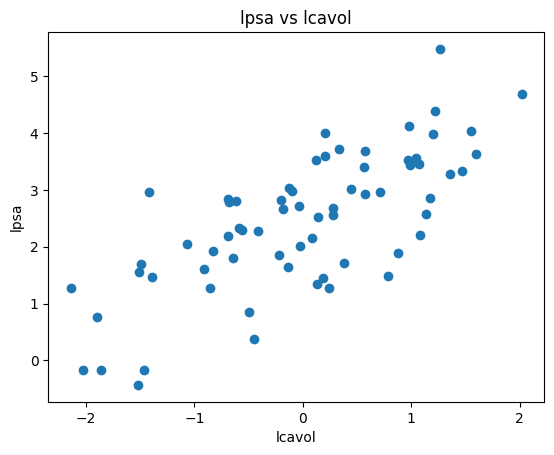

In [69]:
plt.title("lpsa vs lcavol")
plt.xlabel("lcavol")
plt.ylabel("lpsa")
plt.scatter(X_train, y_train);

There looks to be a linear relationship between these variables, and it is easy to imagine a line running through this cloud that could be used to predict lpsa given another lcavol value.

How do we find this line?

OLS or ordinary least squares is one of the most basic methods for finding this line.

But, first what form does this line take?

$$\hat{y} = \beta_0 + \beta_1 x_1$$

This just means our predicted lpsa value equals an intercept plus a slope times whatever lcavol value we plug in.

Our goal is to find the slope and intercept. Just off of look my estimate for the intercept would be ~2.5 and the slope to be 1. Let's plot that and see how it looks.

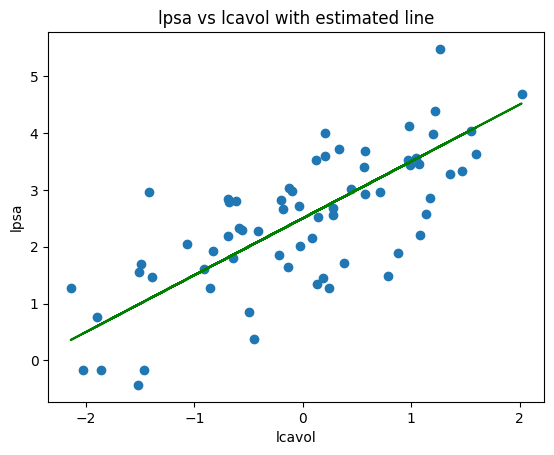

In [70]:
plt.title("lpsa vs lcavol with estimated line")
plt.xlabel("lcavol")
plt.ylabel("lpsa")
plt.plot(X_train, X_train + 2.5, 'g')
plt.scatter(X_train, y_train);

It actually looks pretty good. How do we quantify how good it is?

Well, the line is some distance from each of the actual data points. Let's plot those and see how much error our predicted value has.

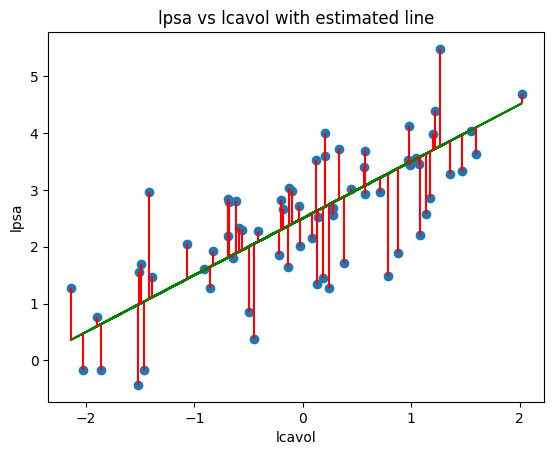

In [71]:
plt.title("lpsa vs lcavol with estimated line")
plt.xlabel("lcavol")
plt.ylabel("lpsa")
plt.plot(X_train, X_train + 2.5, 'g')
plt.vlines(X_train, X_train + 2.5, y_train, 'r')
plt.scatter(X_train, y_train);

To compare different lines of fit we can't just add up these residuals, because the negative and positive residuals will partially cancel out. To work around this we take the residual sum of squares (RSS) also known as the sum of squared error (SSE). This just means we sum up the square of each residual. 

Let's set up a dataframe with all relevant values

In [72]:
ols_df = prostate_df.query("train == 'T'")[['lpsa','lcavol']].copy()
ols_test_df = prostate_df.query("train == 'F'")[['lpsa','lcavol']].copy()
ols_df['f_hat'] = ols_df['lcavol'] + 2  # Our estimate based on the visual guess
ols_df['residual'] = ols_df['lpsa'] - ols_df['f_hat']
ols_df['rs'] = ols_df['residual'] ** 2  # using rs because this isn't the sum
ols_df['rs'].sum() 

59.10293120097886

Our goal will be to find the line that minimizes this number. We can also divide RSS by n to obtain the mean squared error (MSE). This will be done later to be able to compare the model's performance on the training and testing set.

Fortunately there is a nice closed-form solution to minimize this:
$$\hat{\beta} =(X^TX)^{-1} X^{T}y$$
To get an intercept we have to add a column of 1s to X, so let's do that and figure out what our new line is.


In [73]:
X = np.hstack((np.ones((ols_df.shape[0], 1)), ols_df['lcavol'].values.reshape(-1, 1)))
y = np.array(ols_df['lpsa'])

beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
beta

array([2.45234509, 0.88551357])

This means:
$$\hat{y} = 2.45 + 0.88 x_1$$
Let's redo our f_hat, residual, and rss columns based off of this.

In [74]:
ols_df['f_hat'] = beta[0] + beta[1] * ols_df['lcavol']
ols_df['residual'] = ols_df['lpsa'] - ols_df['f_hat']
ols_df['rss'] = ols_df['residual'] ** 2
ols_df['rss'].sum() 

44.52858265645384

Our RSS is improved from the initial guess, so now let's look at another way of calculating our betas:

$$\hat{\beta_1} = \frac{\text{cov}(x_1, y)}{\text{var}(x_1)}$$
$$\hat{\beta_0} = \bar{y} - \hat{\beta}_1 \bar{x_1}$$

So, first let's calculate the covariance and variance, then check if we get the same result.

In [75]:
ols_df['cov'] = (ols_df['lcavol'] - ols_df['lcavol'].mean()) * (ols_df['lpsa'] - ols_df['lpsa'].mean())
ols_df['var_x'] = (ols_df['lcavol'] - ols_df['lcavol'].mean()) ** 2
beta_1 = ols_df['cov'].sum() / ols_df['var_x'].sum()
beta_0 = ols_df['lpsa'].mean() - beta_1 * ols_df['lcavol'].mean()

beta_0, beta_1

(2.4523450850746267, 0.8855135674892511)

And it works! Note that I didn't divide either sum by n - 1 because it would cancel out.

Now let's look at some other things we can calculate.

Let's start with the total sum of squares (TSS or SST) and explained sum of squares (ESS or SSR). ESS being referred to as SSR (sum of squares due to regression) is easy to confuse with RSS. Also, ESS and SSE being different things can be confusing. I like using these names:  

RSS - Residual sum of squares: sum((prediction - actual)**2)
TSS - Total sum of squares: sum((actual - mean of actual)**2)
ESS - Explained sum of squares: sum((prediction - mean of actual)**2)

In [76]:
ols_df['tss'] = (ols_df['lpsa'] - ols_df['lpsa'].mean())**2
ols_df['ess'] = (ols_df['f_hat'] - ols_df['lpsa'].mean())**2

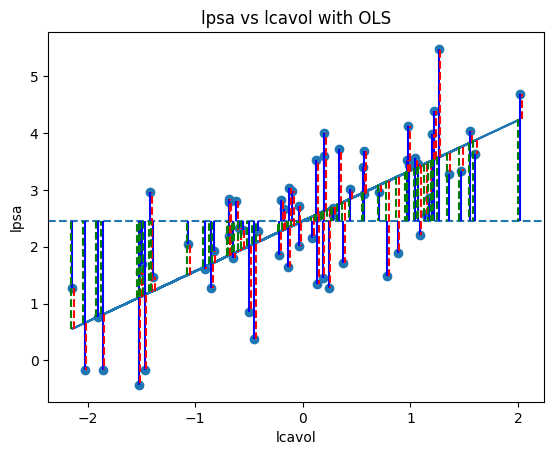

In [77]:
plt.title("lpsa vs lcavol with OLS")
plt.xlabel("lcavol")
plt.ylabel("lpsa")
plt.plot(ols_df['lcavol'], ols_df['f_hat'])  # f_hat
plt.axhline(y=ols_df['lpsa'].mean(), linestyle='--')  # y_bar
plt.vlines(ols_df['lcavol'], ols_df['lpsa'], ols_df['lpsa'].mean(), 'b')  # TSS
plt.vlines(ols_df['lcavol']+0.015, ols_df['f_hat'], ols_df['lpsa'], 'r', linestyles='dashed')  # RSS with offset for visibility
plt.vlines(ols_df['lcavol']-0.015, ols_df['f_hat'], ols_df['lpsa'].mean(), 'g', linestyles='dashed')  # ESS

#plt.vlines(ols_df['lcavol'], ols_df['f_hat'], ols_df['lpsa'], '-r')  # RSS
plt.scatter(ols_df['lcavol'], ols_df['lpsa']);

I know this looks insane, but it shows how TSS(faint blue vertical lines) = RSS(red) + ESS(green).

Now, let's calculate R^2 which measures the proportion of variability in Y that is explained with X. So ideally much closer to 1 than 0.

We can compute this with ESS/TSS or 1 - RSS/TSS

In [78]:
ols_df['ess'].sum() / ols_df['tss'].sum()

0.5375164690552887

In simple linear regression we can also square the correlation to find R^2

In [79]:
ols_df.corr().iloc[1,0]**2

0.5375164690552883

Now let's create a 95% confidence interval using standard error (SE). The 95% confidence interval is the beta ± 2SE

$$\text{SE}(\hat{\beta}_0)^2 = \sigma^2 \left(\frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}\right)
$$

$$\text{SE}(\hat{\beta}_1)^2 = \frac{\sigma^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$

Here $\sigma^2 = \text{Var}(\varepsilon)$ which assumes the errors are uncorrelated and have the same variance. We can estimate sigma with $\text{RSE} = \sqrt{\frac{\text{RSS}}{n - 2}}
$

In [80]:
n = ols_df.shape[0]
sigma_2 = (ols_df['rss'].sum() / (n - 2))

SE_beta_0 = sigma_2 * ((1/n) + (ols_df['lcavol'].mean() / ols_df['var_x'].sum()))
SE_beta_1 = sigma_2 / ols_df['var_x'].sum()

beta_0_95 = (beta[0] - 2 * SE_beta_0, beta[0] + 2 * SE_beta_0)
beta_1_95 = (beta[1] - 2 * SE_beta_1, beta[1] + 2 * SE_beta_1)

beta_0_95, beta_1_95

((2.431895678573385, 2.4727944915758684),
 (0.8647543214955666, 0.9062728134829361))

Now let's compute our t-statistic and p-value, so if the p-value is small enough we can reject the null hypothesis that the coefficient and/or intercept is 0.

With our standard this is simple:
$$t = \frac{\hat{\beta}}{\text{SE}(\hat{\beta})}$$
and the p value is the area under the t-distribution outside + or - the t-statistic. The t-distribution uses degrees of freedom as a parameter where df = n - p - 1. Here p is the number of features which for simple linear regression is 1.

In [81]:
import scipy.stats
simple_df = ols_df.shape[0] - 2

t_stat_0 = beta[0] / SE_beta_0
t_stat_1 = beta[1] / SE_beta_1

# sf is the survivor function is 1 - CDF
# So this doubled is the area outside a deviation of the t-stat on both sides
p_value_0 = scipy.stats.t.sf(abs(t_stat_0), df=simple_df) * 2
p_value_1 = scipy.stats.t.sf(abs(t_stat_1), df=simple_df) * 2

print(f"p_value_0 = {p_value_0}, p_value_1 = {p_value_1}")

p_value_0 = 1.5932687768273576e-97, p_value_1 = 1.8792724715011608e-68


It is common to use a threshold of 1% or 5% as a threshold for the p-value, so this is very much in the clear. 

## Evaluation on testing set

First let's use the model on the testing set and compare the MSE.

In [82]:
ols_test_df['f_hat'] = beta[0] + beta[1] * ols_test_df['lcavol']
ols_test_df['residual'] = ols_test_df['lpsa'] - ols_test_df['f_hat']
ols_test_df['rss'] = ols_test_df['residual'] ** 2

mse_train = ols_df['rss'].sum() / ols_df.shape[0]  
mse_test = ols_test_df['rss'].sum() / ols_test_df.shape[0]

print(f"Training MSE: {mse_train}\nTesting MSE: {mse_test}")

Training MSE: 0.6646057112903558
Testing MSE: 0.49923758910967003


Our MSE is actually lower on the testing which is unexpected. Let's check out a scatterplot with both the training and the testing data points.

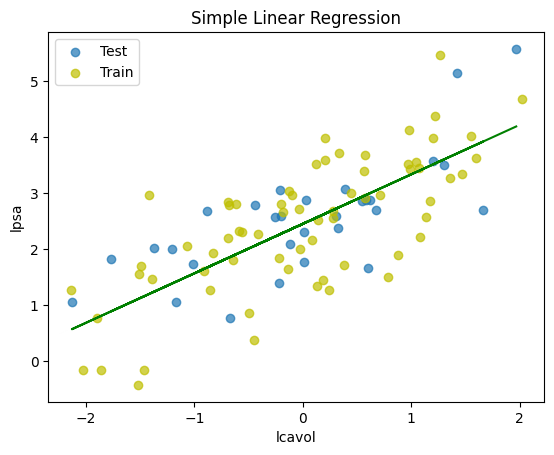

In [83]:
plt.title("Simple Linear Regression")
plt.xlabel("lcavol")
plt.ylabel("lpsa")
plt.plot(ols_test_df['lcavol'], ols_test_df['f_hat'], 'g')
plt.scatter(ols_test_df['lcavol'], ols_test_df['lpsa'], label='Test', alpha=0.7)
plt.scatter(ols_df['lcavol'], ols_df['lpsa'], c='y', label='Train', alpha=0.7)
plt.legend(loc='upper left');

## Multiple Linear Regression
Let's bring in the rest of the features and see what happens. I will keep all features in this notebook, but plan on creating one for topics like feature selection and more in future notebooks.

In [84]:
features = prostate_df.columns.to_list()
features = [item for item in features if item not in ['lpsa', 'train']]

mult_df = prostate_df.query("train == 'T'").copy()
mult_test_df = prostate_df.query("train == 'F'").copy()

mult_df = mult_df.drop(columns=['train'])
mult_test_df = mult_test_df.drop(columns=['train'])

In [85]:
X = np.hstack((np.ones((mult_df.shape[0], 1)),mult_df[features].values))
y = np.array(mult_df['lpsa'])

beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
beta

array([ 2.45234509,  0.71640701,  0.2926424 , -0.14254963,  0.2120076 ,
        0.30961953, -0.28900562, -0.02091352,  0.27734595])

In [117]:
mult_df['f_hat'] = (mult_df.iloc[:,:8] * beta[1:]).sum(axis=1) + beta[0]

In [116]:
mult_df['lpsa']

0    -0.430783
1    -0.162519
2    -0.162519
3    -0.162519
4     0.371564
        ...   
90    4.029806
91    4.129551
92    4.385147
93    4.684443
95    5.477509
Name: lpsa, Length: 67, dtype: float64